In [25]:
import numpy as np

In [26]:
def create_sinwaves(n_samples, wave_length, freq_range, amp_range, phase_range):
    """
    Create a dataset of sin waves with random frequencies, phases and amplitudes.
    """
    X = np.zeros((n_samples, wave_length))
    freqs = np.random.uniform(freq_range[0], freq_range[1], n_samples)
    phases = np.random.uniform(phase_range[0], phase_range[1], n_samples)
    amplitudes = np.random.uniform(amp_range[0], amp_range[1], n_samples)

    for i in range(n_samples):
        X[i,:] = amplitudes[i] * np.sin(2 * np.pi * freqs[i] * np.arange(wave_length) / wave_length + phases[i])
    return X

amplitudes = [0.1, 0.9]
freqs = [1, 4]
phases = [-np.pi, np.pi]

seq_len = 50
samples = 100

y = create_sinwaves(samples, seq_len, freqs, amplitudes, phases)
y.shape

(100, 50)

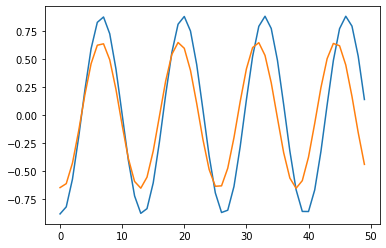

In [27]:
import matplotlib.pyplot as plt

plt.plot(y[0])
plt.plot(y[3])


Number of training data: 128
Sample statistics:  torch.Size([64, 30]) tensor(0.8457) tensor(-0.8489)

Epoch: 0, Step: 0, Loss: 4.118864059448242
Epoch: 0, Step: 1, Loss: 4.019256114959717
Epoch: 50, Step: 0, Loss: 2.755567789077759
Epoch: 50, Step: 1, Loss: 2.2113845348358154
Epoch: 100, Step: 0, Loss: 0.948007345199585
Epoch: 100, Step: 1, Loss: 1.0399597883224487
Epoch: 150, Step: 0, Loss: 0.2609279155731201
Epoch: 150, Step: 1, Loss: 0.259064644575119
Epoch: 200, Step: 0, Loss: 0.1569446623325348
Epoch: 200, Step: 1, Loss: 0.17430643737316132
Epoch: 250, Step: 0, Loss: 0.1201380118727684
Epoch: 250, Step: 1, Loss: 0.11185242235660553
Epoch: 300, Step: 0, Loss: 0.09995020925998688
Epoch: 300, Step: 1, Loss: 0.26018476486206055
Epoch: 350, Step: 0, Loss: 0.04580462723970413
Epoch: 350, Step: 1, Loss: 0.04763616621494293


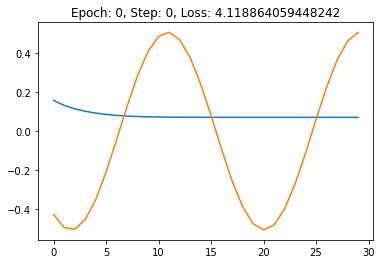

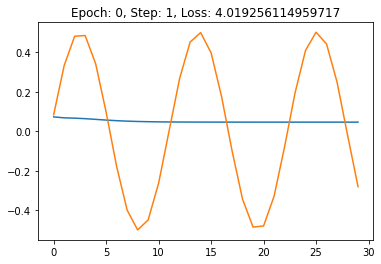

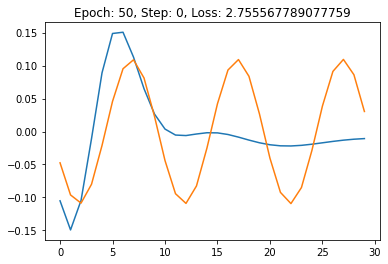

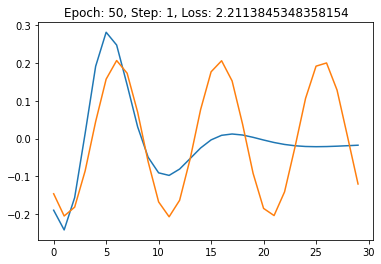

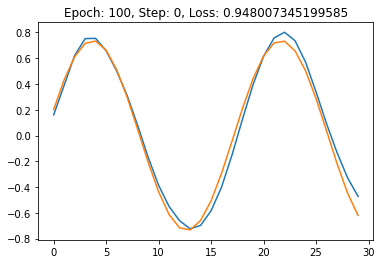

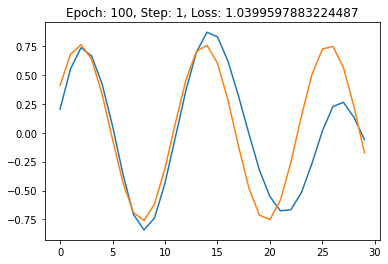

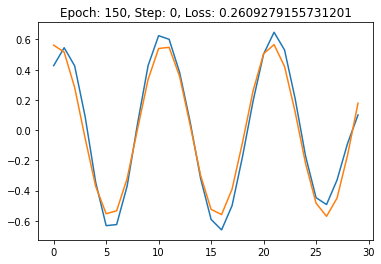

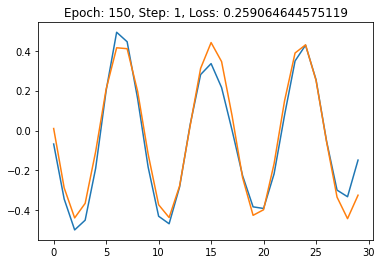

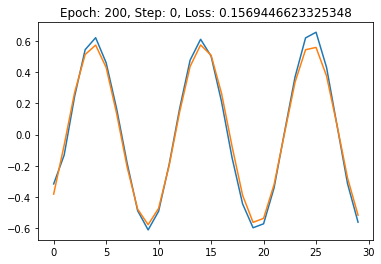

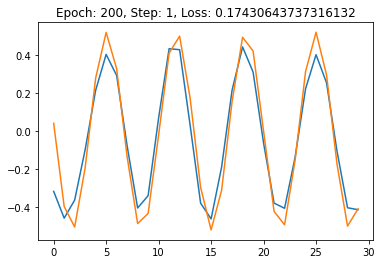

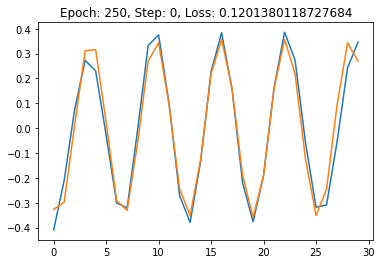

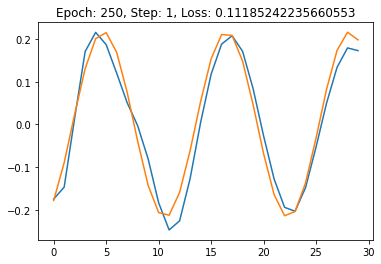

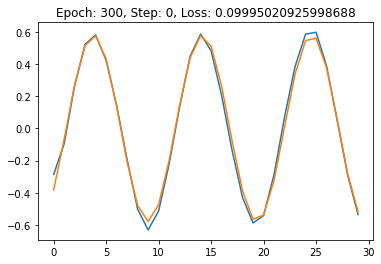

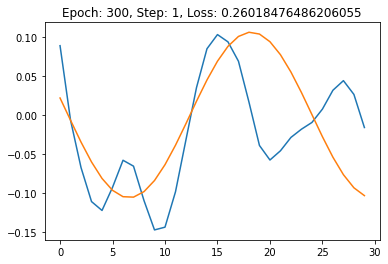

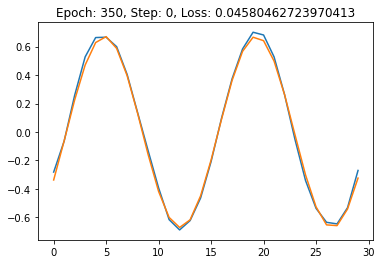

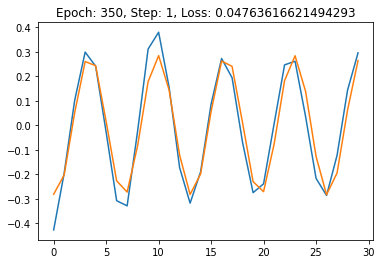

<Figure size 432x288 with 0 Axes>

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt


class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=False)
        self.hidden = None
    def init_hidden(self, batch_size):
        # the first is the hidden h
        # the second is the cell c
        return (torch.ones( self.num_layers, batch_size, self.hidden_size, dtype=torch.float32),
                torch.ones( self.num_layers, batch_size, self.hidden_size, dtype=torch.float32))

    def forward(self, x):
        _, self.hidden = self.lstm(x, self.hidden)
        return self.hidden


class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super(LSTMDecoder, self).__init__()

        self.lstm = nn.LSTM(1, hidden_size, num_layers=num_layers, batch_first=False)
        self.linear = nn.Linear(hidden_size, 1)
        #self.out = nn.Tanh()

    def forward(self, targets, hidden, criterion):
        batch_size, seq_len = targets.size()
        input_s = torch.tensor([[0.0]] * batch_size, dtype=torch.float32).unsqueeze(0)
        outputs = []
        loss = 0
        for i in range(seq_len):
            output, hidden = self.lstm(input_s, hidden)
            pred = self.linear(output[-1]) # inputs short term memory cell
            input_s = pred.unsqueeze(0)
            outputs.append(pred)

            loss += criterion(pred.squeeze(), targets[:,i])

        return outputs, loss


def create_sinwaves(n_samples, wave_length, freq_range, amp_range, phase_range):
    """
    Create a dataset of sin waves with random frequencies, phases and amplitudes.
    """
    X = np.zeros((n_samples, wave_length))
    freqs = np.random.uniform(freq_range[0], freq_range[1], n_samples)
    phases = np.random.uniform(phase_range[0], phase_range[1], n_samples)
    amplitudes = np.random.uniform(amp_range[0], amp_range[1], n_samples)

    for i in range(n_samples):
        X[i,:] = amplitudes[i] * np.sin(2 * np.pi * freqs[i] * np.arange(wave_length) / wave_length + phases[i])
    return X

SEQUENCE_LENGTH = 30
BATCH_SIZE = 64
N = 100

hidden_size = 64
num_layers = 2


amplitudes = [0.1, 0.9]
freqs = [1, 4]
phases = [-np.pi, np.pi]


# Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)

# 2 sequences (to match the batch size) of length 6 (for the 6h into the future)


transforms = transforms.Compose([transforms.ToTensor(), ]) # transforms.Normalize(0.5, 0.5)

sinwaves = create_sinwaves(n_samples=N, wave_length=SEQUENCE_LENGTH, freq_range=(1, 5),
                           amp_range=(0.1, 0.9), phase_range=(-np.pi, np.pi))


inputs = transforms(sinwaves).transpose(0,1)

train_data = TensorDataset(torch.from_numpy(sinwaves).float(), torch.from_numpy(sinwaves).float())
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
print("Number of training data: {}".format(len(train_dl) * BATCH_SIZE))

sample, _ = next(iter(train_dl))
print("Sample statistics: ", sample.shape, sample.max(), sample.min(), end="\n\n")



# 5 is the number of features of your data points
encoder = LSTMEncoder(SEQUENCE_LENGTH, hidden_size, num_layers=num_layers)
decoder = LSTMDecoder(hidden_size, num_layers=num_layers)
# Create optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='mean')

#
# Do one complete forward & backward pass
epochs = 400

encoder.train()
decoder.train()
for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.unsqueeze(0)

        # Zero gradients of both optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # Reset hidden state of encoder for current batch
        encoder.hidden = encoder.init_hidden(inputs.size()[1])

        # Do forward pass through encoder
        hidden = encoder(inputs)
        # Do forward pass through decoder (decoder gets hidden state from encoder)
        outputs, loss = decoder(targets, hidden, criterion)
        # Backpropagation
        loss.backward()
        # Update parameters
        encoder_optimizer.step()
        decoder_optimizer.step()
        # Print loss for every 100 steps
        if epoch % 50 == 0:
            print("Epoch: {}, Step: {}, Loss: {}".format(epoch, i, loss.item()))
            #print("outputs shape", torch.stack(outputs)[:,0].detach().numpy().squeeze(1).shape)
            #print("targets shape", targets[0].detach().numpy().shape)
            plt.plot(torch.stack(outputs)[:,0].detach().numpy().squeeze(1))
            plt.plot(targets[0].detach().numpy())
            plt.title("Epoch: {}, Step: {}, Loss: {}".format(epoch, i, loss.item()))
            #plt.figure(figsize=(7,7))
            plt.figure()


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=False)
        self.hidden = None

    def init_hidden(self, batch_size):
        return (torch.zeros( self.num_layers, batch_size, self.hidden_size, dtype=torch.float32),
                torch.zeros( self.num_layers, batch_size, self.hidden_size, dtype=torch.float32))

    def forward(self, inputs):
        # Push through RNN layer (the ouput is irrelevant)
        _, self.hidden = self.lstm(inputs, self.hidden)
        return self.hidden


class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # input_size=1 since the output are single values
        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, outputs, hidden, criterion):
        batch_size, num_steps = outputs.shape
        # Create initial start value/token
        input = torch.tensor([[0.0]] * batch_size, dtype=torch.float32)
        # Convert (batch_size, output_size) to (seq_len, batch_size, output_size)
        input = input.unsqueeze(0)
        print("input shape", input.shape)
        print("outputs shape", outputs.shape)
        print("hidden shape", hidden[0].shape, hidden[1].shape)

        loss = 0
        for i in range(num_steps):
            # Push current input through LSTM: (seq_len=1, batch_size, input_size=1)
            output, hidden = self.lstm(input, hidden)
            # Push the output of last step through linear layer; returns (batch_size, 1)
            output = self.out(output[-1])
            # Generate input for next step by adding seq_len dimension (see above)
            input = output.unsqueeze(0)
            # Compute loss between predicted value and true value
            loss += criterion(output.squeeze(), outputs[:, i])
        return loss


if __name__ == '__main__':

    # 5 is the number of features of your data points
    encoder = Encoder(5, 128)
    decoder = Decoder(128)
    # Create optimizers for encoder and decoder
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Some toy data: 2 sequences of length 10 with 5 features for each data point
    inputs = [
        [
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
        ],
        [
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
            [0.5, 0.2, 0.3, 0.4, 0.1],
        ]
    ]

    inputs = torch.tensor(np.array(inputs), dtype=torch.float)
    # Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
    inputs = inputs.transpose(1,0)

    # 2 sequences (to match the batch size) of length 6 (for the 6h into the future)
    outputs = [ [0.1, 0.2, 0.3, 0.1, 0.2, 0.3], [0.3, 0.2, 0.1, 0.3, 0.2, 0.1] ]
    outputs = torch.tensor(np.array(outputs), dtype=torch.float)

    #
    # Do one complete forward & backward pass
    #
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset hidden state of encoder for current batch
    encoder.hidden = encoder.init_hidden(inputs.shape[1])
    # Do forward pass through encoder
    hidden = encoder(inputs)
    # Do forward pass through decoder (decoder gets hidden state from encoder)
    loss = decoder(outputs, hidden, criterion)
    # Backpropagation
    loss.backward()
    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    print("Loss:", loss.item())

input shape torch.Size([1, 2, 1])
outputs shape torch.Size([2, 6])
hidden shape torch.Size([1, 2, 128]) torch.Size([1, 2, 128])
Loss: 0.2170298993587494
